## Goal
The problem that we are going to solve here is that given a set of features that describe a house in Boston, our machine learning model must predict the house price. To train our machine learning model with boston housing data, we will be using scikit-learn’s boston dataset.

## Data
In this dataset, each row describes a boston town or suburb. There are 506 rows and 13 attributes (features) with a target column (price).

- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per 10,000usd
- PTRATIO pupil-teacher ratio by town
- B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT % lower status of the population

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./src')
from scipy.stats import skew

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
from eda import bivariate_plot, col_types, impute_missing, missing_value_summary
from eda import data_summary, scatter_plot, bin_plot, heatmap_corr
from sklearn_utils import coef_df, univariate_f_regression, vif, var_importance, drop_high_vif, regression_metrics

## Loading data

In [4]:
raw_data = pd.read_csv('data/no_use/boston_housing.csv'
            #,nrows = 10
            #,parse_dates=['signup_time', 'purchase_time']
            ,dtype = {'CHAS':str})
raw_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MDEV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
raw_data.shape

(506, 14)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    object 
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MDEV     506 non-null    float64
dtypes: float64(13), object(1)
memory usage: 55.5+ KB


In [7]:
raw_data.describe(include='O')

,CHAS
count,506
unique,2
top,0.0
freq,471


In [8]:
data_summary(raw_data)

,count,mean,std,min,25%,50%,75%,max,missing,missing %,1.5iqr outliers,outliers %
CRIM,506.0,3.593761,8.596783,0.00632,0.082045,0.25651,3.647422,88.9762,0,0.0,65,12.85
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000,0,0.0,68,13.44
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400,0,0.0,0,0.00
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710,0,0.0,0,0.00
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800,0,0.0,30,5.93
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000,0,0.0,0,0.00
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265,0,0.0,5,0.99
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000,0,0.0,0,0.00
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000,0,0.0,0,0.00
PTRATIO,506.0,18.455534,2.164946,12.60000,17.400000,19.05000,20.200000,22.0000,0,0.0,15,2.96


## visualization

<AxesSubplot:xlabel='MDEV', ylabel='Count'>

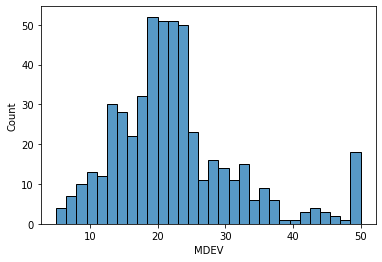

In [9]:
y_col = 'MDEV'
sns.histplot(raw_data[y_col], bins = 30)

In [10]:
skew(raw_data[y_col])

1.104810822864635

<AxesSubplot:xlabel='MDEV', ylabel='Count'>

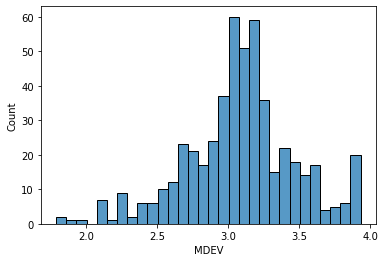

In [11]:
sns.histplot(np.log1p(raw_data[y_col]), bins = 30)

In [12]:
raw_data['log1p_price'] = np.log1p(raw_data[y_col])
log_y_col = 'log1p_price'

In [13]:
skew(raw_data['log1p_price'] )

-0.24052778511563527

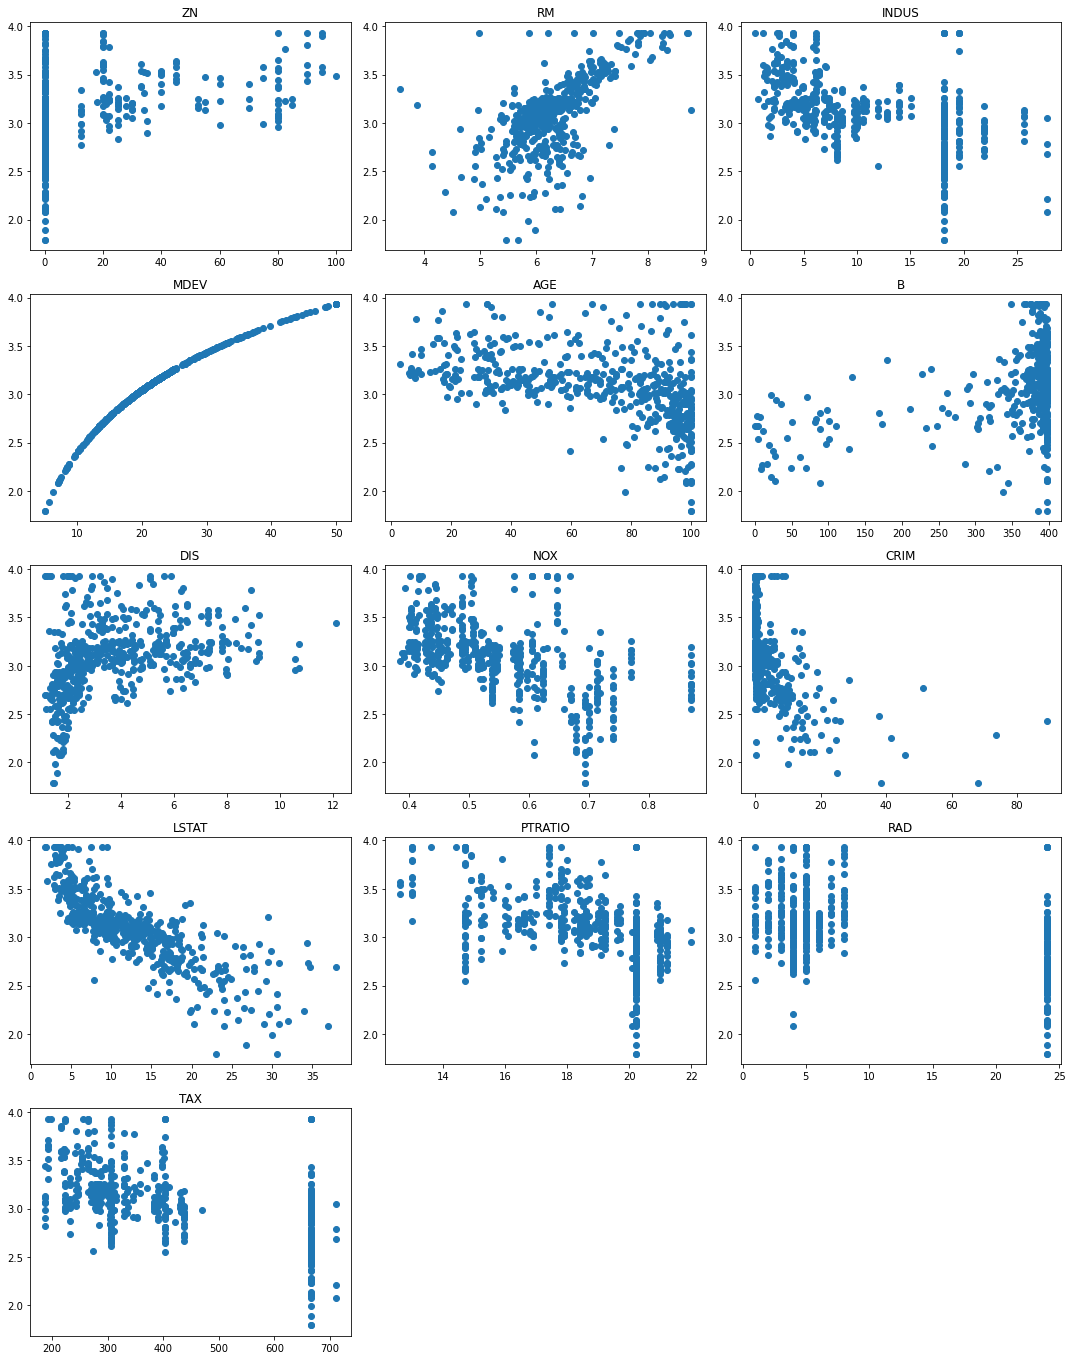

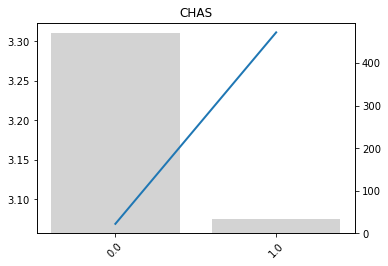

In [14]:
bivariate_plot(raw_data,log_y_col)

In [15]:
num_cols, cat_cols = col_types(raw_data, log_y_col)
num_cols.remove(y_col)

Numerical Columns are:


['CRIM',
 'ZN',
 'INDUS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'MDEV']


 Categorical Columns are:


['CHAS']

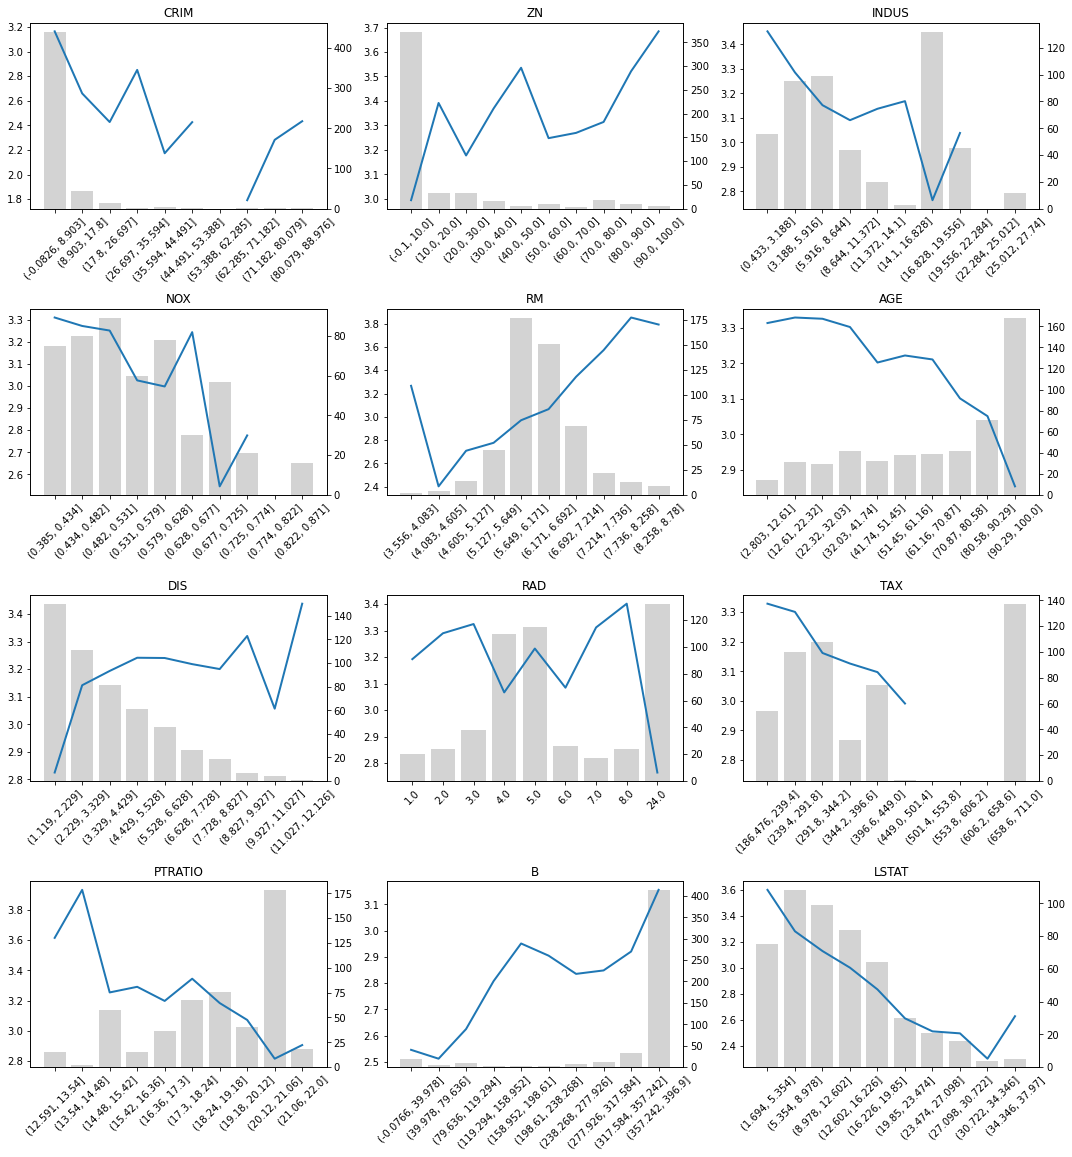

In [16]:
bin_plot(raw_data, num_cols, log_y_col)

## Feacture selection

### Numerical features

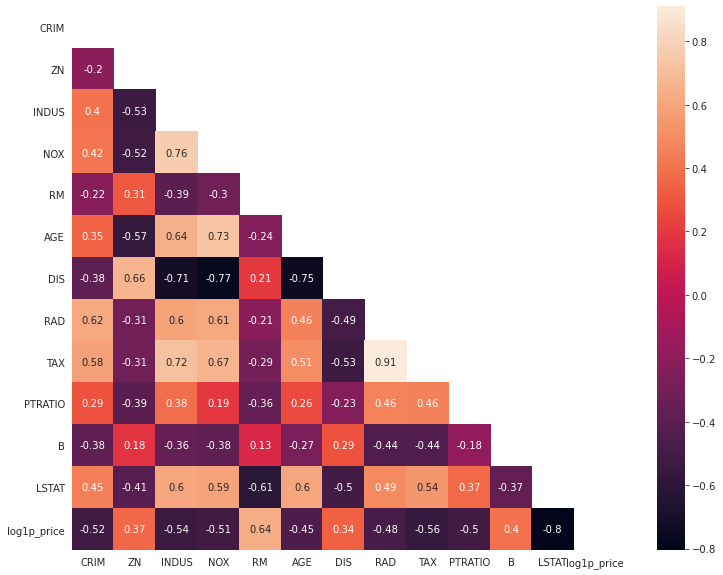

In [17]:
cor = raw_data[num_cols+[log_y_col]].corr()
heatmap_corr(cor, figsize=(15, 10))

In [18]:
to_drop = ['RAD', 'DIS']

In [19]:
num_cols_vars = list(set(num_cols)- set(to_drop) ) 

In [20]:
f_values = univariate_f_regression(raw_data[num_cols_vars], raw_data[log_y_col])

,F-value,p-val
LSTAT,923.3098,0.0
RM,344.8603,0.0
TAX,228.8704,0.0
INDUS,208.8313,0.0
CRIM,184.6247,0.0
NOX,176.1428,0.0
PTRATIO,171.6656,0.0
AGE,129.5159,0.0
B,96.4427,0.0
ZN,77.5325,0.0


### Categorical features

In [21]:
dummy_df = pd.get_dummies(raw_data[cat_cols])

In [22]:
model_data = pd.concat([raw_data.drop(to_drop, axis = 1), dummy_df], axis=1)
model_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,TAX,PTRATIO,B,LSTAT,MDEV,log1p_price,CHAS_0.0,CHAS_1.0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,296.0,15.3,396.90,4.98,24.0,3.218876,1,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,242.0,17.8,396.90,9.14,21.6,3.117950,1,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,242.0,17.8,392.83,4.03,34.7,3.575151,1,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,222.0,18.7,394.63,2.94,33.4,3.538057,1,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,222.0,18.7,396.90,5.33,36.2,3.616309,1,0


In [23]:
model_vars = num_cols_vars + ['CHAS_1.0']

In [24]:
vif(model_data[model_vars], model_vars)

,feature,VIF
5,NOX,3.949741
2,INDUS,3.510481
9,TAX,3.413438
7,LSTAT,2.929998
3,AGE,2.822167
0,ZN,1.897054
1,RM,1.849155
8,PTRATIO,1.719970
6,CRIM,1.621562
4,B,1.337747


In [25]:
remain_features = drop_high_vif(model_data[model_vars], model_vars, 3)

,feature,VIF
5,LSTAT,2.894274
2,AGE,2.291662
7,TAX,2.207954
1,RM,1.812672
0,ZN,1.695235
4,CRIM,1.606452
6,PTRATIO,1.499468
3,B,1.326382
8,CHAS_1.0,1.045847


In [26]:
model_vars = remain_features['feature'].to_list()

In [27]:
model_vars

['LSTAT', 'AGE', 'TAX', 'RM', 'ZN', 'CRIM', 'PTRATIO', 'B', 'CHAS_1.0']

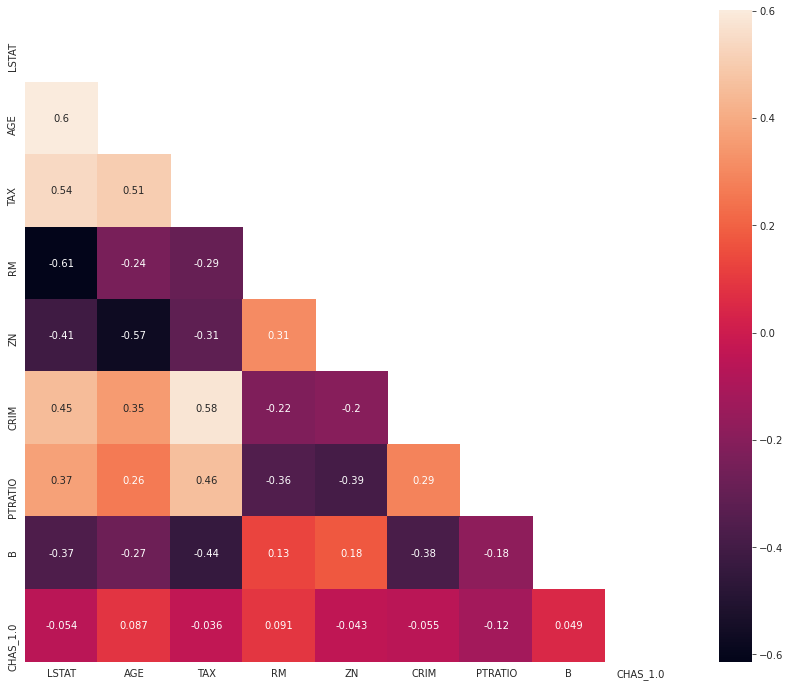

In [28]:
corr = model_data[model_vars].corr()
heatmap_corr(corr)

## Linear regression model

In [29]:
train,test = train_test_split(model_data, train_size = 0.8)
train = train.copy()
test = test.copy()

#model_vars = ['CRIM', 'CHAS', 'NOX', 'RM',  'PTRATIO', 'B', 'LSTAT']

In [30]:
lin_reg = LinearRegression().fit(train[model_vars], train[log_y_col])
coef_df(lin_reg, model_vars)

,Estimate
Intercept,3.213038
LSTAT,-0.029866
AGE,0.001197
TAX,-0.000031
RM,0.097077
ZN,0.000276
CRIM,-0.006779
PTRATIO,-0.030661
B,0.000427
CHAS_1.0,0.114758


,metric,Score
0,R-Squared,0.7552
1,Adjusted R-Squared,0.7496
2,RMSE,0.1895
3,MAE,0.1360


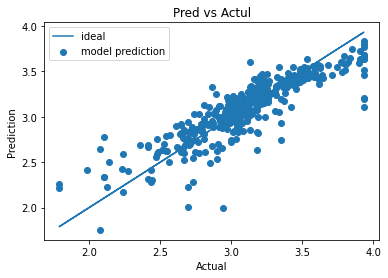

In [31]:
regression_metrics(lin_reg, train[model_vars], train[log_y_col]);

,metric,Score
0,R-Squared,0.7517
1,Adjusted R-Squared,0.7274
2,RMSE,0.1988
3,MAE,0.1418


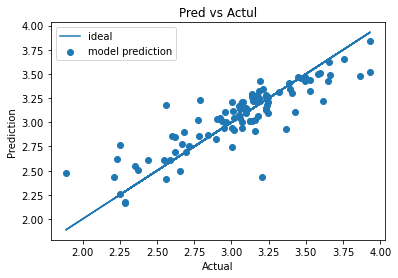

In [32]:
regression_metrics(lin_reg, test[model_vars], test[log_y_col]);

In [33]:
lcv = LassoCV(cv = KFold(shuffle=True)).fit(train[model_vars], train[log_y_col])

In [34]:
lcv.alpha_

0.034562092574200974

In [35]:
coef_df(lcv,model_vars)

,Estimate
Intercept,3.827274
LSTAT,-0.036656
AGE,0.001941
TAX,-0.000094
RM,0.000000
ZN,0.000869
CRIM,-0.005677
PTRATIO,-0.027054
B,0.000394
CHAS_1.0,0.000000


,metric,Score
0,R-Squared,0.6964
1,Adjusted R-Squared,0.6667
2,RMSE,0.2198
3,MAE,0.1599


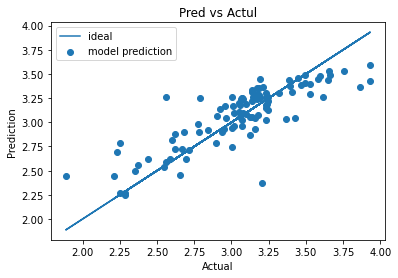

,metric,Score
0,R-Squared,0.6964
1,Adjusted R-Squared,0.6667
2,RMSE,0.2198
3,MAE,0.1599


In [36]:
regression_metrics(lcv, test[model_vars], test[log_y_col])

## random forest model

In [37]:
model_vars_rf = model_vars

In [38]:
rf_reg = RandomForestRegressor()
hp = GridSearchCV(
    rf_reg,
    param_grid={
        'n_estimators': range(150,200,10),
        'max_depth': range(4,8,1),
        'min_samples_leaf': range(1,4,1)
    },
    cv = KFold(n_splits=5, shuffle=True),
    n_jobs = -1
).fit(train[model_vars_rf], train[log_y_col])

In [39]:
hp.best_estimator_

RandomForestRegressor(max_depth=7, n_estimators=190)

In [40]:
rf_mod = hp.best_estimator_.fit(train[model_vars_rf], train[log_y_col])

In [41]:
vi = var_importance(rf_mod, model_vars_rf)
vi

,Importance,cumsum
LSTAT,0.604783,0.605
RM,0.183325,0.788
CRIM,0.133101,0.921
AGE,0.025363,0.947
TAX,0.019276,0.966
B,0.018749,0.985
PTRATIO,0.013128,0.998
CHAS_1.0,0.001438,0.999
ZN,0.000837,1.000


,metric,Score
0,R-Squared,0.9565
1,Adjusted R-Squared,0.9555
2,RMSE,0.0798
3,MAE,0.0594


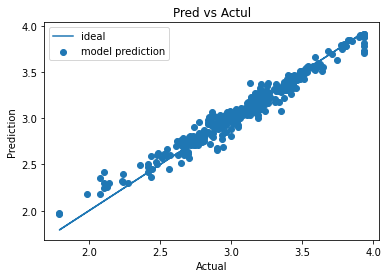

In [42]:
regression_metrics(rf_mod, train[model_vars_rf], train[log_y_col]);

,metric,Score
0,R-Squared,0.8324
1,Adjusted R-Squared,0.8160
2,RMSE,0.1633
3,MAE,0.1166


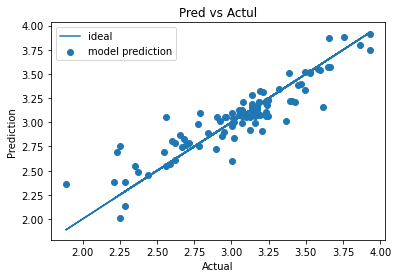

In [43]:
regression_metrics(rf_mod, test[model_vars_rf], test[log_y_col]);